## **Reviews Analysis using VRBO data**

In [10]:
import os
import pandas as pd
import plotly.express as px
from transformers import pipeline
import re
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yuto1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
cu_path = os.getcwd()

### **Sentiment Analysis (Twitter-roBERTa-base transformers)**

In this section, we perform the sentiment analyis. To perform this, I used "Twitter-roBERTa-base" transformers to label the review text into whther it is  negative or positive or neutral.

In [12]:
file = cu_path + "/vrbo_formatted.csv"
df = pd.read_csv(file , encoding = "utf-8")

I transformed the review text. Since all of the text was combined with '|||' for each properties, I made the list of the text so that we can use them to transformers model.

In [13]:
for index , i in zip(df.index , df["reviews_text"]):
    if pd.isna(i) == False:
        i = i.split("|||")
    else:
        i = []
    df.at[index ,"reviews_text"] = i

We only select the properties which have the reviews comments and star rating.Since it's only 743 properties hold this condition, we will use almost 30%(743/2503) of the whose dataset. Also, I retrieved the unnecessary characters that may cause errors when using the transformers model.

In [14]:
df = df[(df["star_rating"].isna() == False) & (len(df["reviews_text"]) != 0)]

In [15]:
for index , text_list in zip(df.index , df["reviews_text"]):
    reviews_text_list = []
    for i in text_list:
        i = re.sub(r"\\n" , "" , i)
        reviews_text_list.append(i)
    df.at[index,"reviews_text"] = reviews_text_list

In [16]:
pipe_model = pipeline("text-classification" , model='cardiffnlp/twitter-roberta-base-sentiment')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [17]:
count = 0
df["reviews_label"] = ""
for index , i in zip(df.index , df["reviews_text"]):
    label_list = []
    for r in i:
        try:
            temp_dict = {}
            results = pipe_model(r)
            for each in results:
                temp_dict[each["label"]] = each["score"]
            r = dict(sorted(temp_dict.items(), key=lambda item: item[1] , reverse = True))
            label = str(list(r.keys())[0])
            label_list.append(label)
        except:
            label_list.append("")
            count = count + 1
    df.at[index , "reviews_label"] = label_list

In [20]:
for index , each_list in zip(df.index , df["reviews_label"]):
    new_list = []
    for i in each_list:
        new_list.append(i)
    df.at[index , "reviews_label"] = new_list

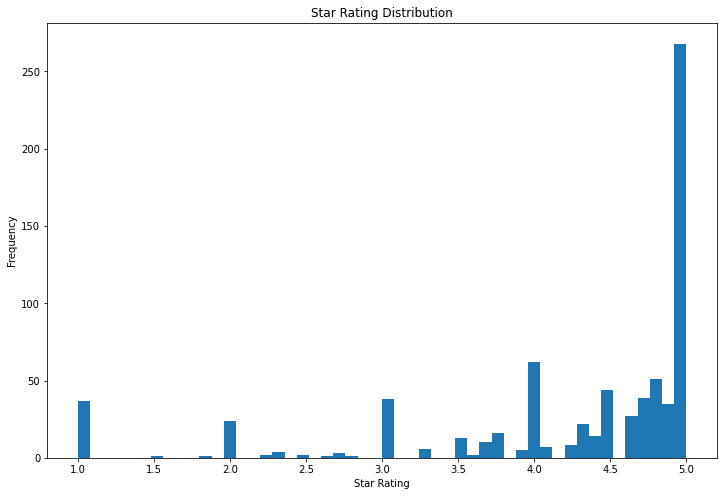

In [21]:
df["star_rating"].plot.hist(bins=50,
                            figsize=(12,8),
                            title='Star Rating Distribution')
plt.xlabel('Star Rating')
plt.show()

First, I visualize the distribution of ratings in order to caetgorize higher and lower rated groups in the next step. From this visualization, we can see that most of the rating is over 4, but there are properties whose rating is below 4 to some extent.


I have created two groups. One is the group with the highest rating and the other is the group with the lowest rating. The definition of a highly rated group is when star_rating is higher than 3, and the definition of a low rated group is when star_rating is 3 or less.

In [22]:
df_low = df[df["star_rating"] <= 3]
df_high = df[df["star_rating"] > 3]

In [23]:
df_low_label = df_low["reviews_label"].tolist()
df_low_label_list = []
for each in df_low_label:
    for i in each:
        df_low_label_list.append(i) 

df_high_label = df_high["reviews_label"].tolist()
df_high_label_list = []
for each in df_high_label:
    for i in each:
        df_high_label_list.append(i) 


low_label = ["Lower rating"] * len(df_low_label_list)
high_label = ["Higher rating"] * len(df_high_label_list)

low_label.extend(high_label)
df_low_label_list.extend(df_high_label_list)

label_df = pd.DataFrame(list(zip(low_label,df_low_label_list)) , columns = ["rating_group" , "reaction"])

name_dict = {"LABEL_0" : "Negative" , "LABEL_1" : "Neutral" , "LABEL_2" : "Positive"}
label_df["reaction"] = label_df["reaction"].replace(name_dict)
label_df = label_df.groupby(["rating_group","reaction"]).size()
label_df = label_df.reset_index()
label_df = label_df.rename(columns = {0 : "count"})

<AxesSubplot:title={'center':'Reaction to properties in higher ratings and lower ratings'}, xlabel='rating_group'>

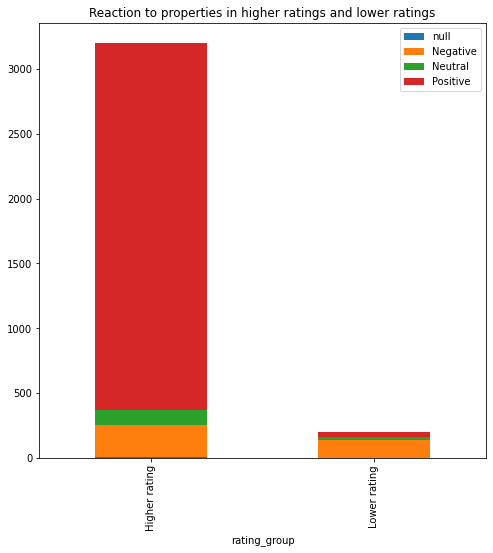

In [24]:
label_df_vis = label_df.pivot(index=["rating_group"], columns=["reaction"], values="count")
label_df_vis = label_df_vis.reset_index()
label_df_vis.columns = ["rating_group","null","Negative","Neutral","Positive"]
label_df_vis.plot.bar(x='rating_group', stacked=True,
                  figsize=(8,8),
                  title='Reaction to properties in higher ratings and lower ratings')

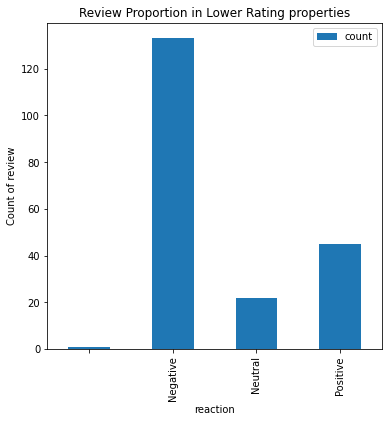

In [25]:
label_df_low = label_df[label_df["rating_group"] == "Lower rating"]
label_df_low.plot.bar(x='reaction', stacked=True,
                  figsize=(6,6),
                  title='Review Proportion in Lower Rating properties')
plt.ylabel('Count of review')
plt.show()

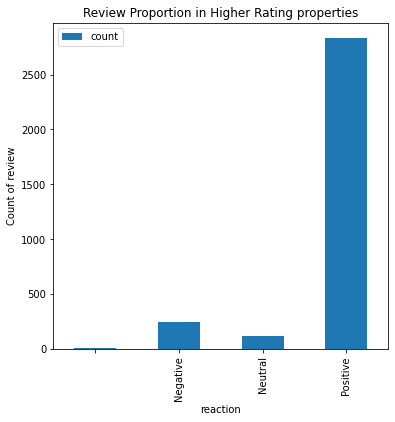

In [26]:
label_df_high = label_df[label_df["rating_group"] == "Higher rating"]
label_df_high.plot.bar(x='reaction', stacked=True,
                  figsize=(6,6),
                  title='Review Proportion in Higher Rating properties')
plt.ylabel('Count of review')
plt.show()

### **Latent Dirichlet Allocation (LDA)**

To identify what topics are important in lower rated properties' negative comment

First, I transform the text data

In [28]:
lower_negative_comment_list = []
df_low_review = df_low[["reviews_text" , "reviews_label"]]
for text_list , label_list in zip(df_low_review["reviews_text"] , df_low_review["reviews_label"]):
    for text , label in zip(text_list , label_list):
        text = text.replace("['" , "").replace("']" , "")
        text = re.sub('[,\.!?]', '', text)
        text = text.lower()
        if label == "LABEL_0":
            lower_negative_comment_list.append(text)

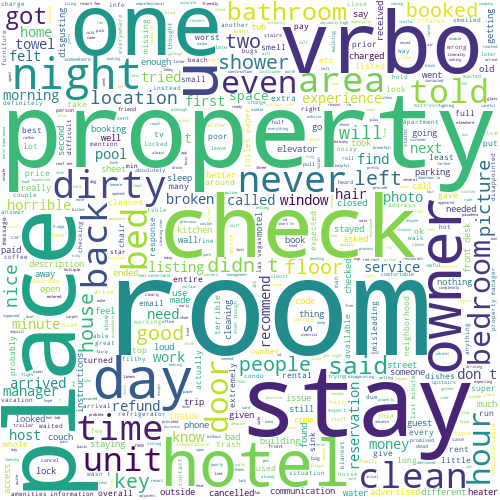

In [29]:
long_string = ','.join(lower_negative_comment_list)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',width=500, height=500)
wordcloud.generate(long_string)
wordcloud.to_image()

I delete the stopwords. I also add the stopwords to delete based on the wordcloud above.

In [30]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','one' ,
                   'u' , 'told' , 'didn t', 'would',
                  'overall','well' , 'could', 'next'])

In [31]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data_words = list(sent_to_words(lower_negative_comment_list))
# print(data_words)
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['never', 'stay', 'anywhere', 'company', 'owns', 'start', 'drove', 'hours', 'get', 'took', 'mins', 'find', 'get', 'never', 'given', 'instructions', 'enter', 'woke', 'morning', 'charged', 'refundable', 'deposit', 'times', 'morning', 'woken', 'someone', 'working', 'us', 'garage', 'rented']


In [32]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 3), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [33]:
result_list = []
for each_list in data_words:
    for each in each_list:
        result_list.append(each)

This is the wordcloud of the data which is used in LDA model

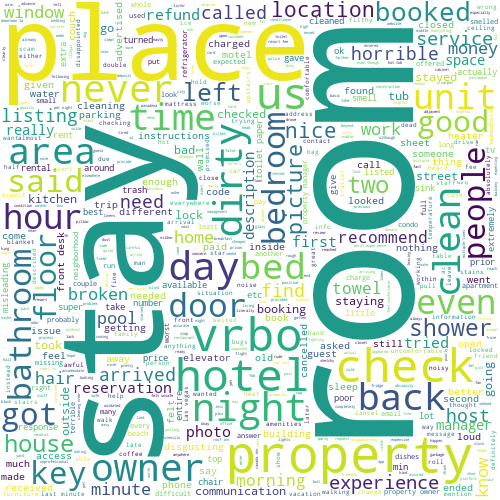

In [34]:
long_string = ','.join(result_list)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',width=500, height=500)
wordcloud.generate(long_string)
wordcloud.to_image()

Create the LDA model.

In [36]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.020*"room" + 0.009*"dirty" + 0.009*"hotel" + 0.008*"check" + 0.008*"get" '
  '+ 0.007*"left" + 0.006*"stay" + 0.006*"services" + 0.006*"place" + '
  '0.005*"us"'),
 (1,
  '0.019*"property" + 0.011*"place" + 0.010*"stay" + 0.007*"get" + '
  '0.007*"vrbo" + 0.006*"key" + 0.006*"two" + 0.006*"experience" + '
  '0.005*"never" + 0.005*"check"'),
 (2,
  '0.016*"stay" + 0.010*"get" + 0.008*"house" + 0.007*"booked" + 0.007*"like" '
  '+ 0.007*"experience" + 0.007*"us" + 0.006*"also" + 0.006*"got" + '
  '0.006*"vrbo"'),
 (3,
  '0.023*"room" + 0.013*"stay" + 0.008*"area" + 0.007*"never" + 0.006*"say" + '
  '0.006*"lock" + 0.006*"place" + 0.006*"like" + 0.006*"door" + 0.005*"least"'),
 (4,
  '0.009*"room" + 0.009*"place" + 0.008*"check" + 0.008*"area" + '
  '0.007*"property" + 0.007*"like" + 0.006*"get" + 0.006*"us" + 0.005*"street" '
  '+ 0.005*"clean"'),
 (5,
  '0.011*"hotel" + 0.009*"day" + 0.008*"elevator" + 0.008*"property" + '
  '0.008*"stay" + 0.007*"get" + 0.007*"hot" + 0.007*"u

From the result of the first two visualizations, we can see that the proportion of negative reviews is large in the lower rating group. On the other hand, the proportion of negative reviews is quite
low and one of the positive reviews is large in the higher rating group.


From the result of the LDA model, it might be hard to label the name for each topic. However, we can describe in topic number 0, there are “dirty”, “services”, “room” which
represent this topic. Moreover, in topic number 1, there are “dirty”, “property”, “hot”. Furthermore, in topic 3, there are "door", "lock", "never".

From these topics, it might be possible to interpret that rooms and properties are dirty, or broken and these facts might lead to the negative reviews.